# **ArangoRDF**

<img src="https://github.com/ArangoDB-Community/ArangoRDF/blob/main/examples/assets/adb_logo.png?raw=1" alt="rdf" width="60"/>
<img src="https://github.com/ArangoDB-Community/ArangoRDF/blob/main/examples/assets/rdf_logo.png?raw=1" alt="rdf" width="50"/>

# Setup

In [ ]:
%%capture
!pip install arango-datasets
!pip install adb-cloud-connector
!pip install arango-rdf

In [ ]:
import json

# ArangoDB
from arango import ArangoClient
from arango_rdf import ArangoRDF
from arango_datasets import Datasets
from adb_cloud_connector import get_temp_credentials

# RDF
from rdflib import Graph, ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDFS, XSD

In [ ]:
def get_graph(data: str, is_conjunctive_graph: bool = False) -> Graph:
  g = ConjunctiveGraph() if is_conjunctive_graph else Graph()
  g.parse(data=data, format='trig' if is_conjunctive_graph else 'ttl')
  return g

# Understanding RDF

RDF is a standard model for data interchange on the Web. RDF has features that facilitate data merging even if the underlying schemas differ, and it specifically supports the evolution of schemas over time without requiring all the data consumers to be changed.

RDF extends the linking structure of the Web to use URIs to name the relationship between things as well as the two ends of the link (this is usually referred to as a "triple"). Using this simple model, it allows structured and semi-structured data to be mixed, exposed, and shared across different applications.

This linking structure forms a directed, labeled graph, where the edges represent the named link between two resources, represented by the graph nodes. This graph view is the easiest possible mental model for RDF and is often used in easy-to-understand visual explanations.

Resources to get started:

* [RDF Primer](https://www.w3.org/TR/rdf11-concepts/)
* [RDFLib (Python)](https://pypi.org/project/rdflib/)
* [One Example for Modeling RDF as ArangoDB Graphs](https://www.arangodb.com/docs/stable/data-modeling-graphs-from-rdf.html)


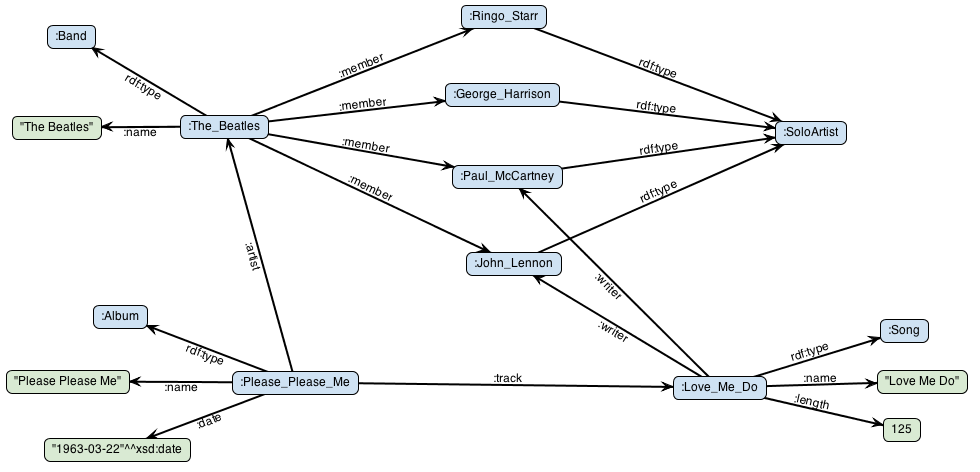

[RDFLib](https://github.com/RDFLib/rdflib) is a pure Python package for working with RDF.

RDFLib aims to be a pythonic RDF API. RDFLib's main data object is a `Graph` which is a Python collection of RDF Subject, Predicate, Object Triples:

To create graph and load it with RDF data from DBPedia then print the results:

In [ ]:
g = Graph()
g.parse('http://dbpedia.org/resource/Semantic_Web')

for s, p, o in g:
    print(s, p, o)

The components of the triples are URIs (resources) or Literals (values).

URIs are grouped together by namespace, common namespaces are included in RDFLib:

In [ ]:
from rdflib.namespace import DC, DCTERMS, DOAP, FOAF, SKOS, OWL, RDF, RDFS, VOID, XMLNS, XSD

You can use them like this:



In [ ]:
g = Graph()
semweb = URIRef('http://dbpedia.org/resource/Semantic_Web')
val = g.value(semweb, RDFS.label)

Where `RDFS` is the RDFS namespace, `XSD` the XML Schema Datatypes namespace and `g.value` returns an object of the triple-pattern given (or an arbitrary one if multiple exist).

Or like this, adding a triple to a graph `g`:

In [ ]:
g.add((
    URIRef("http://example.com/person/nick"),
    FOAF.givenName,
    Literal("Nick", datatype=XSD.string)
))

The triple (in n-triples notation) `<http://example.com/person/nick> <http://xmlns.com/foaf/0.1/givenName> "Nick"^^<http://www.w3.org/2001/XMLSchema#string> .` is created where the property `FOAF.givenName` is the URI `<http://xmlns.com/foaf/0.1/givenName>` and `XSD.string` is the URI `<http://www.w3.org/2001/XMLSchema#string>`.

You can bind namespaces to prefixes to shorten the URIs for RDF/XML, Turtle, N3, TriG, TriX & JSON-LD serializations:

In [ ]:
g.bind("foaf", FOAF)
g.bind("xsd", XSD)

This will allow the n-triples triple above to be serialised like this:



In [ ]:
print(g.serialize(format="turtle"))

New Namespaces can also be defined:



In [ ]:
dbpedia = Namespace('http://dbpedia.org/ontology/')

abstracts = list(x for x in g.objects(semweb, dbpedia['abstract']) if x.language=='en')

# Setup ArangoDB

In [ ]:
# Request temporary instance from the managed ArangoDB Cloud Service.
con = get_temp_credentials()
print(json.dumps(con, indent=2))

# Connect to the db via the python-arango driver
db = ArangoClient(hosts=con["url"]).db(
    con["dbName"],
    con["username"],
    con["password"],
    verify=True
  )

# Instantiate ArangoRDF

Connect ArangoRDF to our temporary ArangoDB instance:

In [ ]:
adbrdf = ArangoRDF(db)

# <u>RDF to ArangoDB</u>

#### ❗ RPT vs PGT ❗



ArangoRDF's RDF-to-ArangoDB functionality has been implemented using concepts described in the paper [*Transforming RDF-star to Property Graphs: A Preliminary Analysis of Transformation Approaches*](https://arxiv.org/abs/2210.05781).

**TL;DR**:

ArangoRDF has 2 RDF-to-ArangoDB transformation methods:

1.   **RDF-topology Preserving Transformation** (RPT): `ArangoRDF.rdf_to_arangodb_by_rpt()`

2.   **Property Graph Transformation** (PGT): `ArangoRDF.rdf_to_arangodb_by_pgt()`

RPT preserves the RDF Graph structure by transforming each RDF Statement into an ArangoDB Edge.

PGT ensures that Datatype Property Statements (i.e Literal Statements) are mapped as ArangoDB Document Properties.

```ttl
@prefix ex: <http://example.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
ex:book ex:publish_date "1963-03-22"^^xsd:date .
ex:book ex:pages "100"^^xsd:integer .
ex:book ex:cover 20 .
ex:book ex:index 55 .
```

| RPT | PGT |
|:-------------------------:|:-------------------------:|
| ![image](https://user-images.githubusercontent.com/43019056/232347662-ab48ebfb-e215-4aff-af28-a5915414a8fd.png) | ![image](https://user-images.githubusercontent.com/43019056/232347681-c899ef09-53c7-44de-861e-6a98d448b473.png) |


#### Cases

RDF Graph Cases taken from the paper [*Transforming RDF-star to Property Graphs: A Preliminary Analysis of Transformation Approaches*](https://arxiv.org/abs/2210.05781)

In [ ]:
# Case 1: Standard RDF statement

data = """
@prefix ex: <http://example.com/> .

ex:alice a ex:Person .
ex:bob a ex:Person .
ex:alice ex:meets ex:bob .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.1: Predicate as subject and literal as object

data = """
@prefix ex: <http://example.com/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

ex:Sam ex:mentor ex:Lee .
ex:mentor rdfs:label "project supervisor" .
ex:mentor ex:name "mentor's name" .

ex:Sam a ex:Person .
ex:Lee a ex:Person .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.2: Predicate as subject and RDF resource as object

data = """
@prefix ex: <http://example.com/> .

ex:Martin ex:mentorJoe ex:Joe.
ex:mentorJoe ex:alias ex:teacher .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.3: Predicate as subject and RDF property as object - rdfs:subPropertyOf

data = """
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix ex: <http://example.com/> .

ex:Jan a ex:Person .
ex:Leo a ex:Person .
ex:Jan ex:supervise ex:Leo .

ex:supervise rdfs:subPropertyOf ex:administer .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.4: Predicate as subject and RDF class as object - rdf:type

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>.

ex:Tom ex:friend ex:Chris .
ex:friend rdf:type ex:relation .
"""

g = Graph()
g.parse(data=data)

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 3: Data types and language tags
# Case 3.1: Datatype property statements with different data types of the literal objects

data = """
@prefix ex: <http://example.com/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:book ex:publish_date "1963-03-22" .
ex:book ex:pages "100"^^xsd:integer .
ex:book ex:cover 20 .
ex:book ex:index "55" .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 3: Data types and language tags
# Case 3.2: Datatype property statements with different language tags of the literal objects
# NOTE: PGT will currently discard the language tags!

data = """
@prefix ex: <http://example.com/> .

ex:book ex:title "Book"@en.
ex:book ex:title "Bog"@da.
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 4: RDF list

data = """
@prefix ex: <http://example.com/> .

ex:List1 ex:contents ("one" "two" "three").
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 5: Blank nodes

data = """
@prefix ex: <http://example.com/> .

ex:bob ex:nationality _:c .
_:c ex:country "Canada" .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 6: Named graphs

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

ex:Monica ex:employer ex:ArangoDB .

ex:Graph1 {
    ex:Monica a ex:Entity .
    ex:Management a ex:Skill .
    ex:Monica ex:name "Monica" .
    ex:Monica ex:homepage <http://www.Monicahompage.org> .
    ex:Monica ex:hasSkill ex:Management .
    ex:Monica ex:dateOfBirth "1963-03-22".
}

ex:Graph2 {
    ex:Programming a ex:Skill .
    <http://www.Monicahompage.org> a ex:Website .
    ex:Monica a ex:Person .
    ex:Person rdfs:subClassOf ex:Entity .
    ex:Monica ex:hasSkill ex:Programming .
}
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data, True), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data, True), overwrite_graph=True)

In [ ]:
# Case 7: Multiple types for resources - rdf:type

data = """
@prefix : <http://example.com/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix adb: <http://www.arangodb.com/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .

:alice a :Arson .
:alice a :Author .

:Zenkey rdfs:subClassOf :Zebra .
:Zenkey rdfs:subClassOf :Donkey .
:Donkey rdfs:subClassOf :Animal .
:Zebra rdfs:subClassOf :Animal .
:Human rdfs:subClassOf :Animal .
:Animal rdfs:subClassOf :LivingThing .
:LivingThing rdfs:subClassOf :Thing .
:Thing rdfs:subClassOf :Object .

:charlie a :LivingThing .
:charlie a :Animal .
:charlie a :Zenkey .

:marty a :LivingThing .
:marty a :Animal .
:marty a :Human .
:marty a :Author .

:john a :Singer .
:john a :Writer .
:john a :Guitarist .
:john adb:collection "Artist" .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

Cases 8 - 15: RDF-Star

The [rdflib](https://github.com/RDFLib/rdflib) package hasn't introduced support for [Quoted Triples](https://www.w3.org/TR/rdf12-concepts/#dfn-quoted-triple) yet, so ArangoRDF's support for RDF-star is based on [Triple Reification](https://www.w3.org/wiki/RdfReification).

In [ ]:
# Case 8:  Embedded object property statement in subject position

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:alice;
    rdf:predicate ex:likes;
    rdf:object ex:bob ;
    ex:certainty "0.5"^^xsd:double .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 9: Embedded datatype property statement in subject position
# Note: PGT does not support this case yet

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:mark;
    rdf:predicate ex:age;
    rdf:object 28 ;
    ex:certainty 1 .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 10: Embedded object property statement in object position

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

_:x a rdf:Statement;
    rdf:subject ex:mainPage;
    rdf:predicate ex:writer;
    rdf:object ex:alice;
    ex:1 "1";
    ex:2 "2";
    ex:3 "3" .

ex:bobshomepage ex:source _:x .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 11: Embedded object property statement in subject position and non-literal object
# Case 11.1: Asserted statement with non-literal object

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:mainPage;
    rdf:predicate ex:writer;
    rdf:object ex:alice ;
    ex:source ex:bobshomepage .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 11: Embedded object property statement in subject position and non-literal object
# Case 11.2: Asserted statement with non-literal object that appears in another asserted statement

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

ex:alex ex:age 25 .

[] a rdf:Statement;
    rdf:subject ex:alice;
    rdf:predicate ex:friend;
    rdf:object ex:bob ;
    ex:mentionedBy ex:alex .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 12: Embedded statement in subject position - object property with rdf:type predicate
# Case 12.1: Asserted statement with rdf:type as predicate

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:mainPage;
    rdf:predicate ex:writer;
    rdf:object ex:alice ;
    rdf:type ex:bobshomepage .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 12: Embedded statement in subject position - object property with rdf:type predicate
# Case 12.2: Embedded statement with rdf:type as predicate

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:lara;
    rdf:predicate rdf:type;
    rdf:object ex:writer ;
    ex:owner ex:journal .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 13: Nested RDF-star statements
# Case 13.1: Nested RDF-star statement in Subject position

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

ex:steve_position_ceo a rdf:Statement;
    rdf:subject ex:steve;
    rdf:predicate ex:position;
    rdf:object ex:CEO .

[] a rdf:Statement;
    rdf:subject ex:steve_position_ceo;
    rdf:predicate ex:mentionedBy;
    rdf:object ex:book;
    ex:source ex:journal .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 13: Nested RDF-star statements
# Case 13.2: Nested RDF-star statements in Object positions

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

ex:steve_position_ceo a rdf:Statement;
    rdf:subject ex:steve;
    rdf:predicate ex:position;
    rdf:object ex:CEO .

ex:book_mentioned_by_steve_position_ceo a rdf:Statement;
    rdf:subject ex:book;
    rdf:predicate ex:mentionedBy;
    rdf:object ex:steve_position_ceo .

[] a rdf:Statement;
    rdf:subject ex:journal;
    rdf:predicate ex:source;
    rdf:object ex:book_mentioned_by_steve_position_ceo .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 14: Multi-valued properties
# Case 14.1: RDF statements with same subject and predicate and different objects

data = """
@prefix ex: <http://example.com/> .

ex:college_page ex:subject "Info_Page";
    ex:subject "aau_page" .

ex:college_page_2 ex:subject "Info_Page" .

ex:college_page ex:link ex:college_page_2 .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)


In [ ]:
# Case 14: Multi-valued properties
# Case 14.2: RDF-star statements with the same subject and predicate and different objects

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt ;
    ex:certainty "0.5"^^xsd:double .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt ;
    ex:certainty 1 .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 14: Multi-valued properties
# Case 14.3: Contexted within Named Graphs

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:college_page_3;
    rdf:predicate ex:subject;
    rdf:object "Info_Page" .


[] a rdf:Statement;
    rdf:subject ex:college_page_4;
    rdf:predicate ex:subject;
    rdf:object "Info_Page", "aau_page" .

ex:Graph1 {
    ex:college_page ex:subject "Info_Page";
        ex:subject "aau_page" .
}

ex:Graph2 {
    [] a rdf:Statement;
        rdf:subject ex:college_page;
        rdf:predicate ex:link;
        rdf:object ex:college_page_3;
        ex:foo "bar";
        ex:foo "bar2" .
}
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data, True), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data, True), overwrite_graph=True)

In [ ]:
# Case 15: Identical embedded RDF-star statements with different asserted statements
# Case 15.1: Basic Reified Statements

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt;
    ex:certainty 0.5 .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt;
    ex:source "text" .

"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 15: Identical embedded RDF-star statements with different asserted statements
# Case 15.2: Basic Reified Statement + regular statement

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt;
    ex:certainty "0.5"^^xsd:double ;
    ex:foo ex:bar .

ex:Mary ex:likes ex:Matt .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 15: Identical embedded RDF-star statements with different asserted statements
# Case 15.2: Basic Reified Statement + duplicate "regular" statement

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt;
    ex:certainty "0.5"^^xsd:double ;
    ex:foo ex:bar .

ex:Mary ex:likes ex:Matt .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 15: Identical embedded RDF-star statements with different asserted statements
# Case 15.3: Basic Reified Statement + duplicate Reified Statement

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt;
    ex:certainty "0.5"^^xsd:double ;
    ex:foo ex:bar .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt .
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), overwrite_graph=True)

In [ ]:
# Case 15: Identical embedded RDF-star statements with different asserted statements
# Case 15.4: Nested Reified Statements with Named Graphs

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
        rdf:subject ex:Mary;
        rdf:predicate ex:likes;
        rdf:object ex:Matt;
        ex:certainty 1 .

ex:Graph1 {
    ex:mary_likes_matt_05 a rdf:Statement;
        rdf:subject ex:Mary;
        rdf:predicate ex:likes;
        rdf:object ex:Matt;
        ex:certainty 0.5 .
}

ex:Graph2 {
    [] a rdf:Statement;
        rdf:subject ex:Mary;
        rdf:predicate ex:likes;
        rdf:object ex:Matt;
        ex:certainty 0.75 .

    [] a rdf:Statement;
        rdf:subject ex:John;
        rdf:predicate ex:said;
        rdf:object ex:mary_likes_matt_05;
        ex:foo "bar" .
}
"""

rpt_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data, True), overwrite_graph=True)
pgt_graph = adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data, True), overwrite_graph=True)

#### Graph Contextualization

❗ Graph Contextualiztion is a work-in-progress feature ❗

Contextualizing an RDF Graph to enhances the Terminology Box of the original RDF Graph. This is done by:

1. Loading the OWL, RDF, and RDFS Ontologies into the RDF Graph
2. Providing Domain & Range Inference
3. Providing Domain & Range Introspection


In [ ]:
data = """
PREFIX : <http://stardog.com/tutorial/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

:The_Beatles      rdf:type  :Band .
:The_Beatles      :name     "The Beatles" .
:The_Beatles      :member   :John_Lennon .
:The_Beatles      :member   :Paul_McCartney .
:The_Beatles      :member   :Ringo_Starr .
:The_Beatles      :member   :George_Harrison .
:John_Lennon      rdf:type  :SoloArtist .
:Paul_McCartney   rdf:type  :SoloArtist .
:Ringo_Starr      rdf:type  :SoloArtist .
:George_Harrison  rdf:type  :SoloArtist .
:Please_Please_Me rdf:type  :Album .
:Please_Please_Me :name     "Please Please Me" .
:Please_Please_Me :date     "1963-03-22"^^xsd:date .
:Please_Please_Me :artist   :The_Beatles .
:Please_Please_Me :track    :Love_Me_Do .
:Love_Me_Do       rdf:type  :Song .
:Love_Me_Do       :name     "Love Me Do" .
:Love_Me_Do       :length   125 .
:Love_Me_Do       :writer   :John_Lennon .
:Love_Me_Do       :writer   :Paul_McCartney .

:McCartney        rdf:type  :Album .
:McCartney        :name     "McCartney" .
:McCartney        :date     "1970-04-17"^^xsd:date .
:McCartney        :artist   :Paul_McCartney .

:Imagine          rdf:type  :Album .
:Imagine          :name     "Imagine" .
:Imagine          :date     "1971-10-11"^^xsd:date .
:Imagine          :artist   :John_Lennon .
"""

rpt_contextualized_graph = adbrdf.rdf_to_arangodb_by_rpt("DataRPT", get_graph(data), contextualize_graph=True, overwrite_graph=True)
pgt_contextualized_graph= adbrdf.rdf_to_arangodb_by_pgt("DataPGT", get_graph(data), contextualize_graph=True, overwrite_graph=True)

# <u>ArangoDB to RDF</u>

We'll be using an ArangoDB-native dataset representing a Knowledge Graph constructed from the [GDETL Project](https://www.gdeltproject.org/).

> GDELT monitors the world's news media from nearly every corner of every country in print, broadcast, and web formats, in over 100 languages, every moment of every day. [...] Put simply, the GDELT Project is a realtime open data global graph over human society as seen through the eyes of the world's news media, reaching deeply into local events, reaction, discourse, and emotions of the most remote corners of the world in near-realtime and making all of this available as an open data firehose to enable research over human society.

The events we're using today range from peaceful protests to significant battles. The image below depicts the connections around an example event:

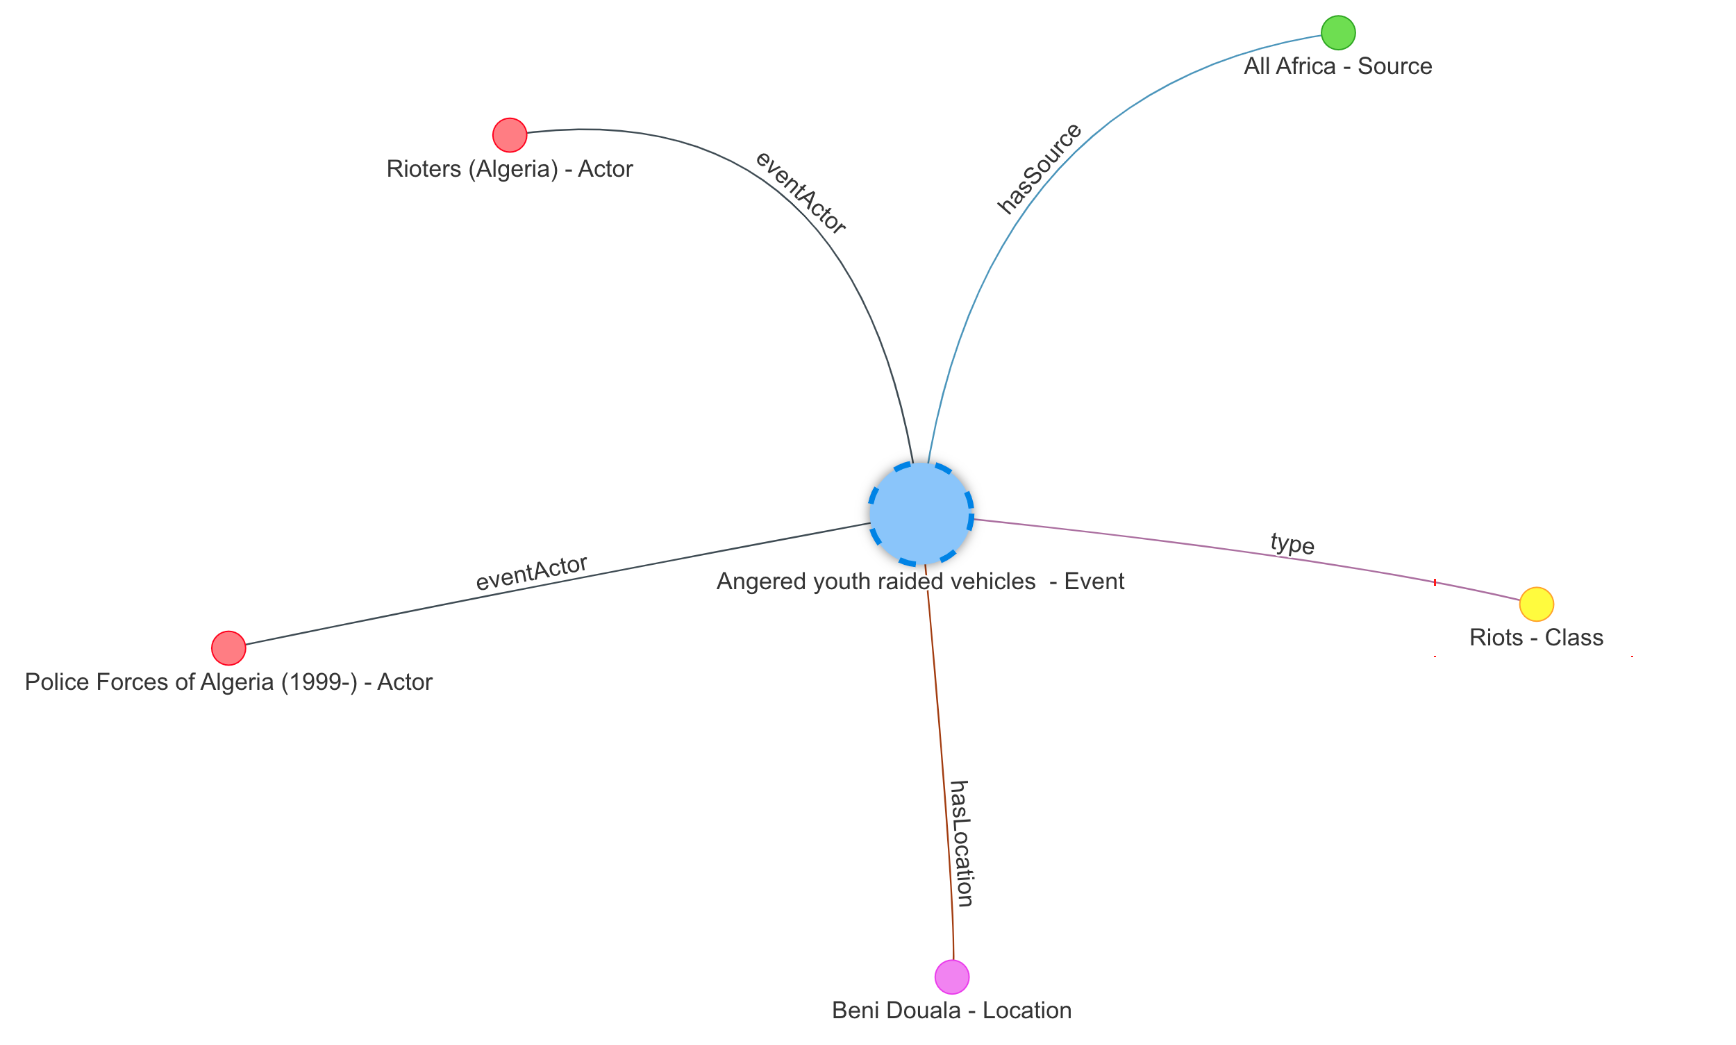

In [ ]:
db.delete_graph("DataRPT", drop_collections=True, ignore_missing=True)
db.delete_graph("DataPGT", drop_collections=True, ignore_missing=True)
Datasets(db).load("OPEN_INTELLIGENCE_ANGOLA")

#### via Graph Name

In [ ]:
rdf_graph = adbrdf.arangodb_graph_to_rdf(name="OPEN_INTELLIGENCE_ANGOLA", rdf_graph=Graph())

print(len(rdf_graph))

#### via Collection Names

In [ ]:
rdf_graph = adbrdf.arangodb_collections_to_rdf(
    name="OPEN_INTELLIGENCE_ANGOLA",
    rdf_graph=Graph(),
    v_cols={"Event", "Actor", "Source"},
    e_cols={"eventActor", "hasSource"},
)

print(len(rdf_graph))

#### via MetaGraph

In [ ]:
rdf_graph = adbrdf.arangodb_to_rdf(
    name="OPEN_INTELLIGENCE_ANGOLA",
    rdf_graph=Graph(),
    metagraph={
        "vertexCollections": {
            "Event": {"date", "description", "fatalities"},
            "Actor": {"name"}
        },
        "edgeCollections": {
            "eventActor": {}
        },
    },
)

print(len(rdf_graph))

# <u>Round-Tripping</u>

In [ ]:
db.delete_graph("DataPGT", drop_collections=True, ignore_missing=True)
db.delete_graph("DataRPT", drop_collections=True, ignore_missing=True)
db.delete_graph("OPEN_INTELLIGENCE_ANGOLA", drop_collections=True, ignore_missing=True)

#### RDF -> ArangoDB -> RDF

In [ ]:
data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

ex:Monica ex:employer ex:ArangoDB .

ex:Graph1 {
    ex:Monica a ex:Entity .
    ex:Management a ex:Skill .
    ex:Monica ex:name "Monica" .
    ex:Monica ex:homepage <http://www.Monicahompage.org> .
    ex:Monica ex:hasSkill ex:Management .
    ex:Monica ex:dateOfBirth "1963-03-22".
}

ex:Graph2 {
    ex:Programming a ex:Skill .
    <http://www.Monicahompage.org> a ex:Website .
    ex:Monica a ex:Person .
    ex:Person rdfs:subClassOf ex:Entity .
    ex:Monica ex:hasSkill ex:Programming .
}
"""

rdf_graph_original = get_graph(data, True)

def graphs_are_identical(rdf_graph_a: Graph, rdf_graph_b: Graph) -> Graph:
    assert rdf_graph_a and rdf_graph_b
    return len(rdf_graph_a - rdf_graph_b) == 0 and len(rdf_graph_b - rdf_graph_a) == 0

In [ ]:
# PGT
adb_graph = adbrdf.rdf_to_arangodb_by_pgt(
    "DataPGT",
    get_graph(data, True),
    overwrite_graph=True,
)

rdf_graph_new = adbrdf.arangodb_graph_to_rdf(
    "DataPGT",
    type(rdf_graph_original)()
)

assert graphs_are_identical(rdf_graph_original, rdf_graph_new)

In [ ]:
# RPT
adb_graph = adbrdf.rdf_to_arangodb_by_rpt(
    "DataRPT",
    get_graph(data, True),
    overwrite_graph=True,
)

rdf_graph_new = adbrdf.arangodb_graph_to_rdf(
    "DataRPT",
    type(rdf_graph_original)()
)

assert graphs_are_identical(rdf_graph_original, rdf_graph_new)

#### ArangoDB -> RDF -> ArangoDB

In [ ]:
db.delete_graph("DataRPT", drop_collections=True, ignore_missing=True)
db.delete_graph("DataPGT", drop_collections=True, ignore_missing=True)

Datasets(db).load("OPEN_INTELLIGENCE_ANGOLA")


def get_adb_graph_count(name: str):
    global db
    adb_graph = db.graph(name)

    e_cols = {col["edge_collection"] for col in adb_graph.edge_definitions()}

    v_count = 0
    for v in db.graph(name).vertex_collections():
        if v in e_cols:
            continue

        v_count += adb_graph.vertex_collection(v).count()

    e_count = 0
    for e_d in adb_graph.edge_definitions():
        e_count += adb_graph.edge_collection(e_d["edge_collection"]).count()

    return (v_count, e_count)

original_v_count, original_e_count = get_adb_graph_count("OPEN_INTELLIGENCE_ANGOLA")

In [ ]:
# PGT
rdf_graph = adbrdf.arangodb_graph_to_rdf(
    "OPEN_INTELLIGENCE_ANGOLA",
    Graph(),
    list_conversion_mode="serialize",
    dict_conversion_mode="serialize",
    include_adb_v_col_statements=True,
    include_adb_v_key_statements=True,
    include_adb_e_key_statements=True,
)


adb_graph = adbrdf.rdf_to_arangodb_by_pgt(
    "OPEN_INTELLIGENCE_ANGOLA",
    rdf_graph,
    overwrite_graph=True
)

property_v_count = adb_graph.vertex_collection("Property").count()

new_v_count, new_e_count = get_adb_graph_count("OPEN_INTELLIGENCE_ANGOLA")

assert original_v_count == new_v_count - property_v_count
assert original_e_count == new_e_count